## Overview
Face detection is one of the most studied topics in the
computer vision community. It is an easy task for humans. In fact, experiments have shown, that even one to three day old babies are able to distinguish between known faces. So how hard could it be for a computer? The answer to this question get busy scientists around the world for over the three past decads.

In this study we will develop and compare two face detection models based on:
- Classical feature-based cascade classifier using the OpenCV library.
- A Multi-task Cascade CNN via the MTCNN library.

The classifiers are already trained and we will use the "Wider Face Dataset" for validation and testing.

For this analysis, we decided to use Google Colab notebook because of the limited resources of my personal laptop, because of the heavy computational challenge to run the models, and the necessity to solve the complicated and tedious installation problems of complex packages like Tensorflow. 

The report is organized as follow:
* [Part 1: Models Development ](#Models-Development )
  * [Face Detection with OpenCV ](#Face-Detection-with-OpenCV )
    * [The Haar Cascade Detector ](#The-Haar-Cascade-Detector )
      * [Parameters Tuning ](#Parameters-tuning )
  * [The Wider Face Dataset ](#The-Wider-Face-Dataset )
    * [Fetch Wider Face Images ](#Fetch-Wider-Face-Images )
  * [The Haar Cascade detector at work ](#The-Haar-Cascade-Detector-at-Work )
  * [Face Detection With Deep Learning ](#Face-Detection-With-Deep-Learning)
    * [The MTCNN Detector at Work ](#The-MTCNN-Detector-at-Work )
* [ Part2: Models Evaluation and comparison ](#Part2:-Models-Evaluation-and-comparison )
  * [Ground Truth Transformation ](#Ground-Truth-Transformation )
  * [Merging Truth and Predictions ](#Merging-Truth-and-Predictions )
  * [Metrics Definition ](#Metrics-Definition )
    * [Intersection over Union (IoU) ](#Intersection-over-Union-(IoU) )
    * [Bounding Box Overlap ](#Bounding-Box-Overlap )
    * [Precision and Recall ](#Precision-and-Recall )
  * [Metrics Visualization ](#Metrics-Visualization )
    * [Overall Precision and Recall ](#Overall-Precision-and-Recall )
    * [Precision and Recall by Event Class ](#Precision-and-Recall-by-Event-Class )
* [Part 3: Understand model when there'no ground truth ](#Part-3:-Understand-model-when-there'no-ground-truth )
  * [Choose a Specific Category ](#Choose-a-Specific-Category )
  * [Distributions Comparison on Validation Dataset ](#Distributions-Comparison-on-Validation-Dataset )
    * [ChiSquare Test ](#ChiSquare-Test )
  * [The Test Dataset ](#The-Test-Dataset )
    * [Fetching Data ](#Fetching-Data )
    * [Running the MTCNN model ](#Running-the-MTCNN-model )
    * [Comparing Distributions ](#Comparing-Distributions )
* [Part 4: Open Question ](#Open-Question )
* [Bibliography ](#Bibliography )

In [85]:
# Import libraries 
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

# Image visualization
import matplotlib.image as mpimg # image module for image reading

import tensorflow as tf
#print(tf.__version__)

import cv2
#print(cv2.__version__)

# Visulazation
import seaborn as sns

# Image processing
from cv2 import imread
from cv2 import imshow
from cv2 import CascadeClassifier
from cv2 import rectangle

#extracting zippped file
import glob

# Geometrical operations
from shapely.geometry import Polygon

#systems
import os
import csv
import time

## Part 1: Models Development

A lot of different algorithms for face detection in photos or, most rescently, videos have been developed across the time. The initial approch were based on Machine Learnign techniques like Principal Component Analysis(PCA), Support Vector Machine(SVM), Naive Bayes Classifiers, and others. But, most recently, after the development of Deep Learning algorithms since 2010, better results, in terms of timing and performance, have been achieved with Convolutional Neural Networks(CNN).

We choose to explore and compare both approches, deploying two detectors representing the status of the art of Machine learning and Deep Learning.


 

#### Face Detection with OpenCV 
The method of face detection in pictures is complicated because of variability present across human faces such as pose, expression, position and orientation, skin colour, the presence of glasses or facial hair, differences in camera gain, lighting conditions, and image resolution.


Given an arbitrary image, the goal of face detection is to determine the presence of faces in the image and, if present, return the image location and extent of each face. 


The feature-based algorithms use, inner features (eyes, nose, mouth) or outer features (head shape, hairline) to successfully recognize a face. Lot of different algorithms have been developd like, EigenFaces, FisherFaces or Local Binary Pattern Histograms (LBPH), but it makes a revolution in this field when, in 1991, Paul Viola and Michel J. Jones [ [1 ](#1 )] comes with their Real-Time Face Detector, which is capable of detecting the faces in real-time with high accuracy. All those algorithms are already trained and publicaly available by the open source projects, OpenCV.

We choose to use the Haar-Cascade because of its better  performance among those type of detectors. 

##### The Haar Cascades Detector
Based on a simple but revolutionary concept of divide and conquer, first the AdaBoost model is used to learn a range of very simple or weak features in each face, that together provide a robust classifier.
The models are then organized into a hierarchy of increasing complexity, called a “cascade“.
Simpler classifiers operate on candidate face regions directly, acting like a coarse filter, whereas complex classifiers operate only on those candidate regions that show the most promising faces.

We first implement a simple function that takes a single image as input and uses a pre-trained Frontal Face Haar cascades detector to identify faces. Finally, the function shows the original image with a bounding box around each detected faces. 


In [99]:
## Function to show image with rectangle box around the recognized faces
def test_face_detection(image, scaleFactor, minNeighbors):
    # load the photograph
    pixels = mpimg.imread(image)
    # load the pre-trained model
    classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    # perform face detection
    bboxes = classifier.detectMultiScale(pixels,scaleFactor, minNeighbors)
    # print bounding box for each detected face
    for box in bboxes:
        #extract
        x, y, width, height = box
        x2, y2 = x + width, y + height
        # draw a rectangle over the pixels
        rectangle(pixels, (x, y), (x2, y2), (255,0,0), 1)

    # show the image
    plt.figure(figsize=(16,9))
    plt.axis("off")
    plt.imshow(pixels)
    plt.show()

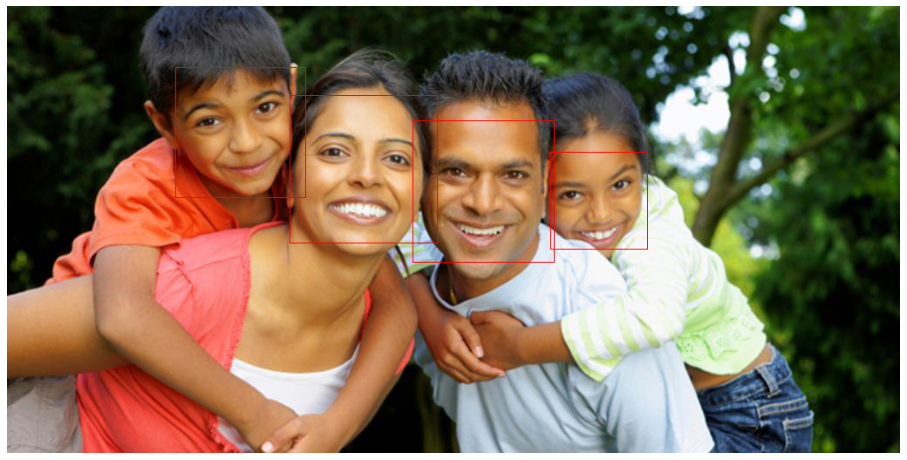

In [100]:
# Make faces detection with a single image
image = '/content/drive/My Drive/SMITHS/wider_face_data/WIDER_val/images/20--Family_Group/20_Family_Group_Family_Group_20_1003.jpg'
scaleFactor = 1.1
minNeighbors = 5
test_face_detection(image, scaleFactor, minNeighbors)

###### Parameters Tuning
The detectMultiScale() function provides some arguments to help tune the usage of the classifier. Two parameters of note are scaleFactor and minNeighbors.

The scaleFactor controls how the input image is scaled prior to detection, e.g. is it scaled up or down, which can help to better find the faces in the image. The default value is 1.1 (10% increase), although this can be lowered to values such as 1.05 (5% increase) or raised to values such as 1.4 (40% increase).

The minNeighbors determines how robust each detection must be in order to be reported, e.g. the number of candidate rectangles that found the face. The default is 3, but this can be lowered to 1 to detect a lot more faces and will likely increase the false positives, or increase to 6 or more to require a lot more confidence before a face is detected. A fast strategy may be to lower (or increase for small photos) the scaleFactor until all faces are detected, then increase the minNeighbors until all false positives disappear, or close to it.
After some tuning, we found a good compromise betwen the two parameters.

Next step is to run the model on our dataset and, instead of simply show the bounding box, save their coordinates for each image in a padas dataframe to be used for the analysis.


### The Wider Face Dataset
The WIDER FACE dataset is currently the largest face detection dataset. It is composed by 32.203 images with 393.703 labelled faces with a high degree of variability in scale, pose and occlusion. The WIDER FACE dataset is organized based on 60 event classes. For each event class the images are splitted in 40%, 10%, 50% as training, validation and testing sets, respectively.

#### Fetch Wider Face Images
First of all, we need to upload images from the validation dataset into an appropriate structure to feed the face detector model. The following function creates a pandas data frame that preserve the images folder structure to keep the event class separation. 

In [88]:
# Fetch images from the Wider Face Dataset
def Fetch_WiderFace_images(images_dir):
    """ Function to upload images into a pandas data frame"""
    
    df = pd.DataFrame(glob.glob(images_dir+'/*/*', recursive=True)).rename({0: 'path'}, axis='columns')
    df['image_name'] = df['path'].apply(lambda x: x.split(images_dir)[1])
    df['event_class'] = df['image_name'].apply(lambda x: x.split('/')[0])
    df['image_name'] = df['image_name'].apply(lambda x: x.split('/')[1])
    return df

In [89]:
# Set the data directory
images_dir = "/content/drive/My Drive/SMITHS/wider_face_data/WIDER_val/images/"
df_images = Fetch_WiderFace_images(images_dir)

In [90]:
df_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3226 entries, 0 to 3225
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   path         3226 non-null   object
 1   image_name   3226 non-null   object
 2   event_class  3226 non-null   object
dtypes: object(3)
memory usage: 75.7+ KB


Now, with image informations properly stored into a data frame, we can use it as input to our model.

### The Haar Cascades Detector at Work
We develop, now, a function to run the Haar Cascade detector on the Wider Face dataset and return, as output, a pandas data frame with all the coordinates of located bounding boxes for each image. The data format of the predictions is the same as the ground truth:
top left corner coordinates,	width, height of each box.

In [91]:
# Implementation of the Haa Cascades Detector. 

def face_detection(classifier, image, scaleFactor, minNeighbors):
    """Function to perform face detection on single image"""
    # Load the photograph
    pixels = cv2.imread(image, cv2.IMREAD_COLOR)
    pixels_gray = cv2.cvtColor(pixels, cv2.COLOR_BGR2GRAY)
    pixels_gray = cv2.equalizeHist(pixels_gray)
    
    # perform face detection
    bboxes = classifier.detectMultiScale(pixels_gray,scaleFactor, minNeighbors)
    #print(bboxes)
    # Save bounding box for each detected face into a data frame
    if len(bboxes)>0:
        df_boxes = pd.DataFrame(bboxes, columns=['p_left', 'p_top', 'p_width', 'p_height'])
        # Add the image name
        df_boxes.insert(loc=0, column='image_path', value=image)
        # Add number of object found
        df_boxes.insert(loc=1, column='p_num_boxes', value=len(bboxes))
    else:
        df_boxes = pd.DataFrame()
        
    return df_boxes
        
        
        
def HaarCascade_FaceDetector(images, scaleFactor, minNeighbors):
    """Function to apply the face detection to the complete dataframe """
   
    # List of dfs
    list_df_boxes = []
    
    # Load the pre-trained model
    classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    # Loop on rows of images data frame
    for row in images.itertuples():
        # Aplly face detection
        df = face_detection(classifier, row.path, scaleFactor, minNeighbors)
        # Append into the list
        if len(df)>0:
            list_df_boxes.append(df)
        
    # Join the data frames into the list
    df_prediction = pd.concat(list_df_boxes)
        
    return df_prediction

Now, we feed the detector with the entire validation data set.

In [44]:
# Apply face detections with HAAR CASCADE
# Parameters
scaleFactor = 1.1
minNeighbors = 5

# Measure time performace
start = time.process_time()

# Run detector
#df_predictions = HaarCascade_FaceDetector(df_test, scaleFactor, minNeighbors) # small sample of images
df_predictions = HaarCascade_FaceDetector(df_images, scaleFactor, minNeighbors) # total sample of images

print("Elapsed time = %f ms"%(time.process_time() - start))

Elapsed time = 4476.337687 ms


Now, we need to modify the structure of the returned data frame to be compatible with the ground truth for an easely comparison.

In [59]:
# Split image_name to extract event_class
df_predictions['event_class'] = df_predictions['image_path'].apply(lambda x: x.split('/')[8])
df_predictions['image_name'] = df_predictions['image_path'].apply(lambda x: x.split('/')[9])
# Remove image_path
df_predictions.drop(['image_path'], axis=1, inplace=True)
df_predictions.head(3)

,p_num_boxes,p_left,p_top,p_width,p_height,event_class,image_name
0,2,313,280,384,384,44--Aerobics,44_Aerobics_Aerobics_44_1032.jpg
1,2,139,774,68,68,44--Aerobics,44_Aerobics_Aerobics_44_1032.jpg
2,4,268,470,61,61,44--Aerobics,44_Aerobics_Aerobics_44_769.jpg


To save time for the analysis, we decided to download the prediction data frame into a .csv file. In this way, in following re-run of the analysis we do not need to run again the model.

In [81]:
# Save the prediction df on csv for saving time
df_predictions.to_csv("/content/drive/My Drive/SMITHS/haar_predicitions.csv", header=True, index=False)

In [92]:
# Read from the csv
df_predictions = pd.read_csv("/content/drive/My Drive/SMITHS/haar_predicitions.csv")

Next step should be the model evaluation, but before that we develop the second model in order to make evaluation and comparison of the models at the same time.

### Face Detection With Deep Learning
A number of Deep Learning methods have been developed and demonstrated for face detection. Perhaps one of the more popular approaches is called “Multi-Task Cascaded Convolutional Neural Network,” or MTCNN[[2 ](#2 )] developed by Kaipeng Zhang, et al. in the 2016.

The MTCNN is popular because it achieved the state-of-the-art results on a range of benchmark datasets, and because it is capable of also recognizing other facial features such as eyes and mouth, called landmark detection.

The network uses a cascade structure with three networks; first the image is rescaled to a range of different sizes (called an image pyramid), then the first model (Proposal Network or P-Net) proposes candidate facial regions, the second model (Refine Network or R-Net) filters the bounding boxes, and the third model (Output Network or O-Net) proposes facial landmarks.

The MTCNN architecture is reasonably complex to implement. Thankfully, there are open source implementations of the architecture that can be trained on new datasets, as well as pre-trained models that can be used directly for face detection.

#### The MTCNN Detector at Work
As for the Haar Cascades model, we need to implement a couple of functions to run the MTCNN model on the Wider Face dataset. But, first of all, we need to install the mtcnn library:

In [93]:
! pip install mtcnn

Then, import the module:

In [94]:
# Import the MTCNN module
from mtcnn import MTCNN

The function need to have exactly the same input and output of the one used previously for the first model. We use default weights of MTCNN to speed up the analysis.

In [95]:
# Implementation of the MTCNN Detector. 

def face_detection(detector, image):
    """Function to perform face detection on single image"""
    # Load the image
    img = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)

    # perform face detection
    faces = detector.detect_faces(img)
    #print(faces)
    ## IMP NEED TO SELECT FROM  DICT faces just KEY = box
    bboxes = [d.get('box') for d in faces]
    #bboxes = faces['box'][0]
    # Save bounding box for each detected face into a data frame
    if len(bboxes)>0:
        df_boxes = pd.DataFrame(bboxes, columns=['p_left', 'p_top', 'p_width', 'p_height'])
        # Add the image name
        df_boxes.insert(loc=0, column='image_path', value=image)
        # Add number of object found
        df_boxes.insert(loc=1, column='p_num_boxes', value=len(bboxes))
    else:
        df_boxes = pd.DataFrame()
        
    return df_boxes   
        
def MTCNN_FaceDetector(images):
    """Function to apply the face detection to the complete dataframe """
   
    # List of dfs
    list_df_boxes = []
    
    # create the detector, using default weights
    detector = MTCNN()
    
    # Loop on rows of images data frame
    for row in images.itertuples():
        # Aplly face detection
        df = face_detection(detector,row.path)
        # Append into the list
        if len(df)>0:
            list_df_boxes.append(df)
        
    # Join the data frames into the list
    df_prediction = pd.concat(list_df_boxes)
        
    return df_prediction

In [73]:
# Apply face detections with MTCNN

# Measure time performace
start = time.process_time()

# Run detector
#df_predictions_mtcnn = MTCNN_FaceDetector(df_test) # small sample of images
df_predictions_mtcnn = MTCNN_FaceDetector(df_images) # total sample of images

print("Elapsed time = %f ms"%(time.process_time() - start))

Elapsed time = 3587.713860 ms


In [74]:
df_predictions_mtcnn.head(3)

,image_path,p_num_boxes,p_left,p_top,p_width,p_height
0,/content/drive/My Drive/SMITHS/wider_face_data...,1,345,254,310,426
0,/content/drive/My Drive/SMITHS/wider_face_data...,5,270,463,60,75
1,/content/drive/My Drive/SMITHS/wider_face_data...,5,582,541,41,54


As before we need to make some adjustments to the format ot the predictions to match the ground truth format and keep the event classes separation. 

In [76]:
# Split image_name to extract event_class
df_predictions_mtcnn['event_class'] = df_predictions_mtcnn['image_path'].apply(lambda x: x.split('/')[8])
df_predictions_mtcnn['image_name'] = df_predictions_mtcnn['image_path'].apply(lambda x: x.split('/')[9])
# Remove image_path
df_predictions_mtcnn.drop(['image_path'], axis=1, inplace=True)
df_predictions_mtcnn.head(3)

,p_num_boxes,p_left,p_top,p_width,p_height,event_class,image_name
0,1,345,254,310,426,44--Aerobics,44_Aerobics_Aerobics_44_1032.jpg
0,5,270,463,60,75,44--Aerobics,44_Aerobics_Aerobics_44_769.jpg
1,5,582,541,41,54,44--Aerobics,44_Aerobics_Aerobics_44_769.jpg


Again, we save the MTCNN prediction data frame into a .csv file to speed up the analysis re-running. 

In [80]:
# Save the prediction df on csv for saving time
df_predictions_mtcnn.to_csv("/content/drive/My Drive/SMITHS/mtcnn_predicitions.csv", header=True, index=False)

In [96]:
# Read the prediction df from csv for saving time
df_predictions_mtcnn = pd.read_csv("/content/drive/My Drive/SMITHS/mtcnn_predicitions.csv")

## Part 2: Models Evaluation and Comparison
After the models development, it is time to evaluate both detectors using the ground truth available for the validation dataset.

### Ground Truth Transformation
We need to upload the info contained into the ground truth file into a pandas dataframe with a similar structure of the prediction dataframes.
The following two functions make the necessary steps for it.

In [97]:
def read_nlines(file_in):
    """ Services function to read the file in blocks on n lines"""
     # extracting image names through first row
    img_path = file_in.readline().strip()
    if not img_path:
        return
    #print(img_path)
    num_boxes = file_in.readline()
    #print(num_boxes)
    count = int(num_boxes)
    list_of_boxes = []
    while count > 0:
        line = file_in.readline()
        # split the line in column
        boxes = line.split()
        # Add to the list
        list_of_boxes.append(boxes)
        #print(boxes)
        count -= 1
        #print(list_of_boxes)
    # Save into a df
    df_boxes = pd.DataFrame(list_of_boxes, columns=['t_left', 't_top', 't_width', 't_height', 'blur', 'expression', 'illumination', 'invalid', 'occlusion', 'pose'])
    # Add the image name
    df_boxes.insert(loc=0, column='image_path', value=str(img_path))
    df_boxes.insert(loc=1, column='t_num_boxes', value=int(num_boxes))
        
    #return df_boxes, num_boxes+2
    return df_boxes

def Ground_Truth_upload(file):
    """Function to upload the ground truth into a data frame"""
    
    # List of blocks
    list_of_blocks = []     
    # Open again file and read
    with open(file, 'r') as file_in:
        #Loop over the file
        while True:
            df = read_nlines(file_in)
            list_of_blocks.append(df)
            #print(df.head(3))
            if df is None:
                break         
        # Join the data frames into the list
        df_ground_truth = pd.concat(list_of_blocks)
        
        return df_ground_truth
        

In [98]:
# Create the data frame for the ground truth  
df_ground_truth = Ground_Truth_upload('/content/drive/My Drive/SMITHS/wider_face_data/WIDER_val/wider_face_val_bbx_gt.txt')
df_ground_truth.head(3)

,image_path,t_num_boxes,t_left,t_top,t_width,t_height,blur,expression,illumination,invalid,occlusion,pose
0,0--Parade/0_Parade_marchingband_1_465.jpg,126,345,211,4,4,2,0,0,0,2,0
1,0--Parade/0_Parade_marchingband_1_465.jpg,126,331,126,3,3,0,0,0,1,0,0
2,0--Parade/0_Parade_marchingband_1_465.jpg,126,250,126,3,4,2,0,0,0,2,0


To keep the event class separation we need to split the path of the images.

In [101]:
# Split image_name to extract event_class
df_ground_truth['event_class'] = df_ground_truth['image_path'].apply(lambda x: x.split('/')[0])
df_ground_truth['image_name'] = df_ground_truth['image_path'].apply(lambda x: x.split('/')[1])
# Remove image_path
df_ground_truth.drop(['image_path'], axis=1, inplace=True)
df_ground_truth.head(3)

,t_num_boxes,t_left,t_top,t_width,t_height,blur,expression,illumination,invalid,occlusion,pose,event_class,image_name
0,126,345,211,4,4,2,0,0,0,2,0,0--Parade,0_Parade_marchingband_1_465.jpg
1,126,331,126,3,3,0,0,0,1,0,0,0--Parade,0_Parade_marchingband_1_465.jpg
2,126,250,126,3,4,2,0,0,0,2,0,0--Parade,0_Parade_marchingband_1_465.jpg


In [102]:
# Convert boxes coordinate to the right type
df_ground_truth['t_left'] = df_ground_truth.t_left.astype(float)
df_ground_truth['t_top'] = df_ground_truth.t_top.astype(float)
df_ground_truth['t_width'] = df_ground_truth.t_width.astype(float)
df_ground_truth['t_height'] = df_ground_truth.t_height.astype(float)
df_ground_truth.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39708 entries, 0 to 2
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   t_num_boxes   39708 non-null  int64  
 1   t_left        39708 non-null  float64
 2   t_top         39708 non-null  float64
 3   t_width       39708 non-null  float64
 4   t_height      39708 non-null  float64
 5   blur          39708 non-null  object 
 6   expression    39708 non-null  object 
 7   illumination  39708 non-null  object 
 8   invalid       39708 non-null  object 
 9   occlusion     39708 non-null  object 
 10  pose          39708 non-null  object 
 11  event_class   39708 non-null  object 
 12  image_name    39708 non-null  object 
dtypes: float64(4), int64(1), object(8)
memory usage: 4.2+ MB


### Merging Truth and Predictions
Now, the ground truth and the predictions are in two different data frame with the same format.
In order to evaluate the performance of the detector we need to merge them.

In [103]:
# Merging predictions from haar detector and ground truth
df_evaluation_haar = pd.merge(df_ground_truth, df_predictions, how='left', on=['image_name', 'event_class'])

In [104]:
df_evaluation_haar.head(3)

,t_num_boxes,t_left,t_top,t_width,t_height,blur,expression,illumination,invalid,occlusion,pose,event_class,image_name,p_num_boxes,p_left,p_top,p_width,p_height
0,126,345.0,211.0,4.0,4.0,2,0,0,0,2,0,0--Parade,0_Parade_marchingband_1_465.jpg,NaN,NaN,NaN,NaN,NaN
1,126,331.0,126.0,3.0,3.0,0,0,0,1,0,0,0--Parade,0_Parade_marchingband_1_465.jpg,NaN,NaN,NaN,NaN,NaN
2,126,250.0,126.0,3.0,4.0,2,0,0,0,2,0,0--Parade,0_Parade_marchingband_1_465.jpg,NaN,NaN,NaN,NaN,NaN


In [105]:
# Merging predictions from mtcnn detector and ground truth
df_evaluation_mtcnn = pd.merge(df_ground_truth, df_predictions_mtcnn, how='left', on=['image_name', 'event_class'])
df_evaluation_mtcnn.head(3)

,t_num_boxes,t_left,t_top,t_width,t_height,blur,expression,illumination,invalid,occlusion,pose,event_class,image_name,p_num_boxes,p_left,p_top,p_width,p_height
0,126,345.0,211.0,4.0,4.0,2,0,0,0,2,0,0--Parade,0_Parade_marchingband_1_465.jpg,NaN,NaN,NaN,NaN,NaN
1,126,331.0,126.0,3.0,3.0,0,0,0,1,0,0,0--Parade,0_Parade_marchingband_1_465.jpg,NaN,NaN,NaN,NaN,NaN
2,126,250.0,126.0,3.0,4.0,2,0,0,0,2,0,0--Parade,0_Parade_marchingband_1_465.jpg,NaN,NaN,NaN,NaN,NaN


### Metrics Definition 
In order to evaluate and compare the performance of the two models we need to define some metrics. An obvious choice is to compare the coordinates of the bounding boxes predicted by the face detector and the actual one from the ground truth.

#### Intersection over Union (IoU)
The general idea is to compute the overlap between the actual bounding box and the predicted one for each face detection.
 
The intesection over union *iou* definition is:

$iou = \frac{area(Bp ∩ Bgt)}{area(Bp ∪ Bgt)}$

where (Bp ∩ Bgt) denotes the intersection of the predicted and ground truth bounding boxes and (Bp ∪ Bgt) their union.

A face detection is considered correct if the *iou* exceed a certain threshold.
The default value of the threshold from litterature is 50%.

All the predicted boxes that pass the cut are considered true positive. Multiple detections of the same object (more than one predicted candidate, for the same actual box) are considered false detections. E.g. 5 detections of a single object counted as 1 true positive and 4 false positives.

In [106]:
# Function to calculate the bounding box overlap
def calculate_iou(box_1, box_2):
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
    return iou

In [107]:
# Function to create boxes coordinates
def create_box(top, left, w, h):
    x0 = left
    y0 = top
    x1 = x0 + w
    y1 = y0 + h
    box = [[x0, y0], [x1, y0], [x1, y1], [x0, y1]] 
    return box

In [108]:
# Function to calculate the
def iou(left1, top1, w1, h1, left2, top2, w2, h2):
    if np.isnan(left2):
        return 0
    box_1 = create_box(top1, left1, w1, h1)
    box_2 = create_box(top2, left2, w2, h2)
    return calculate_iou(box_1, box_2)

The following function create a pandas data frame with all the parameters and perfors the *iou* calculation.

In [109]:
# Function to get df_metrics for both models
def get_df_metrics(df):

  # Calculate iou for each image and for each gt boxes
  df['iou'] = df[['t_left', 't_top', 't_width', 't_height', 'p_left', 'p_top', 'p_width', 'p_height']]. \
        apply(lambda x: iou(*x), axis=1)

  # Take the best candidate
  df_iou = df.groupby(['image_name','t_left', 't_top'])['iou'].max().reset_index()

  # Apply the cut at 0.5 and create the metrics df
  df_metrics = \
  pd.merge(pd.merge(df.groupby(['image_name','event_class'])['p_num_boxes'].max().reset_index(),
                  df_iou[df_iou['iou'] > 0.5].groupby('image_name')['iou'].count().reset_index(). \
                      rename(columns={"iou": "true_pos"}),
                  on='image_name',
                  how='left'),
          df.groupby('image_name')['t_num_boxes'].max().reset_index())
  return df_metrics

Finally, we run the function for both models, the Haar Cascades detector and the MTCNN.

In [110]:
# Create the metrics data frame for both models
df_metrics_haar = get_df_metrics(df_evaluation_haar)
df_metrics_mtcnn = get_df_metrics(df_evaluation_mtcnn)


#### Precision and Recall 
Other two important metrics we can use to evaluate the perfromance of the models, are Precision and Recall.

The precision is defined as the number of *true_positive* over the number of all *predicted positve*.

The recall is defined as the number of *true_positive* over the number of all *actual positive*.

The following function calculates Precision and Recall using the *iou* and the other previously evaluated variables. 

In [111]:
# Function to calculate precision and recall for Detector Models
def get_prec_recal(df):
  df['precision'] = df['true_pos']/df['p_num_boxes']
  df['recall'] = df['true_pos']/df['t_num_boxes']
  # Fill nan with zero
  df.loc[:, ['precision', 'recall']] = df[['precision', 'recall']].fillna(0)
  return df

In [112]:
# Precision and recall evaluation for both models
df_metrics_haar = get_prec_recal(df_metrics_haar)
df_metrics_mtcnn = get_prec_recal(df_metrics_mtcnn)

In [113]:
df_metrics_haar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3226 entries, 0 to 3225
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image_name   3226 non-null   object 
 1   event_class  3226 non-null   object 
 2   p_num_boxes  2548 non-null   float64
 3   true_pos     1891 non-null   float64
 4   t_num_boxes  3226 non-null   int64  
 5   precision    3226 non-null   float64
 6   recall       3226 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 201.6+ KB


As you can see, the metrics data frame contains some null value that come from images with no predicted faces. We need to treat correctly the null values in order not to wrongly calculate precision and recall. 

### Metrics Visualization
The Wider Face dataset contains a great variety of images divided by *event_class*. To better understand how the face detector models perform, it is important to take a look at the metrics overall, and in more details for each event classes. 

#### Overall Precision and Recall
The follwing plots show the distribution per image of the overall Precision and Recall for both models. Left, in blue, the Haar Cascades detector and right, in red, the MTCNN.

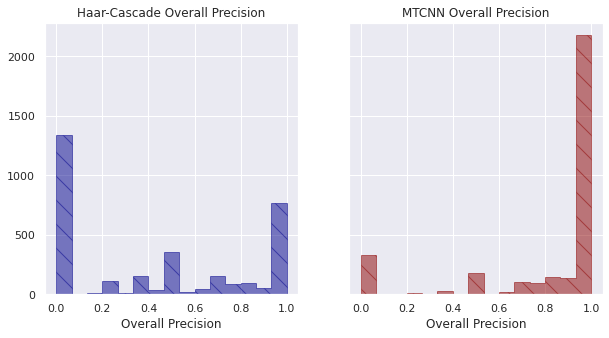

In [114]:
# Plot the overall precision for Haar-Cascade and MTCNN detectors
sns.set()
fig, axes = plt.subplots(sharey=True, figsize=(10,5), nrows=1,ncols=2)
df_metrics_haar['precision'].hist(bins=15,color='darkblue', 
                                  range=(0, 1), alpha=0.5, log=False, 
                                  ax=axes[0], fill=True, histtype='step', hatch='\\')
df_metrics_mtcnn['precision'].hist(bins=15,color='darkred', 
                                   range=(0, 1), alpha=0.5, log=False, 
                                   ax=axes[1], fill=True, histtype='step', hatch='\\')
axes[0].set_title('Haar-Cascade Overall Precision')
axes[1].set_title('MTCNN Overall Precision')
for ax in axes.flat:
    ax.set(xlabel='Overall Precision')

The peak at zero represents the number of images for which the models do not detected any faces. 
As you can see, the MTCNN performs lot better than the Haar Cascades. With the most part of the distribution located at higher precision values and a reduced number of images with no face detection. 

Same consideration for the Recall. Again the MTCNN model shows an higher recall than the Haar Cascades.

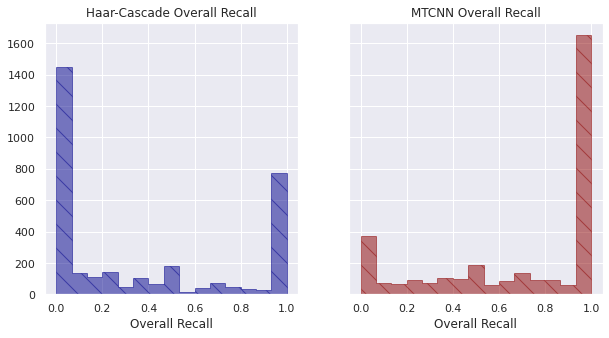

In [115]:
# Plot the overall recall for Haar-Cascade and MTCNN detectors
fig, axes = plt.subplots(sharey=True, figsize=(10,5), nrows=1,ncols=2)
df_metrics_haar['recall'].hist(bins=15,color='darkblue', 
                               range=(0, 1), alpha=0.5, log=False, 
                               ax=axes[0], fill=True, histtype='step', hatch='\\')
df_metrics_mtcnn['recall'].hist(bins=15,color='darkred', 
                                range=(0, 1), alpha=0.5, log=False, 
                                ax=axes[1], fill=True, histtype='step', hatch='\\')
axes[0].set_title('Haar-Cascade Overall Recall')
axes[1].set_title('MTCNN Overall Recall')
for ax in axes.flat:
    ax.set(xlabel='Overall Recall')

To evaluate the overall precision and recall for both detector models, we use the following function.

In [116]:
# Function to evaluate the overall Precision and Recall
def get_overall_prec_rec(df):
  omp = (df['true_pos'].sum()/df['p_num_boxes'].sum())
  omr = (df['true_pos'].sum()/df['t_num_boxes'].sum())
  return omp, omr

In [117]:
# Evaluation for Harr-Cascade
overall_mean_precision_haar, overall_mean_recall_harr = get_overall_prec_rec(df_metrics_haar)
print(f'The Haar Cascade overall precision is {overall_mean_precision_haar:.3f}, \
recall is {overall_mean_recall_harr:.3f}.')

The Haar Cascade overall precision is 0.636, recall is 0.147.


In [118]:
# Evaluation for MTCNN
overall_mean_precision_mtcnn, overall_mean_recall_mtcnn = get_overall_prec_rec(df_metrics_mtcnn)
print(f'The MTCNN overall precision is {overall_mean_precision_mtcnn:.3f},\
recall is {overall_mean_recall_mtcnn:.3f}.')

The MTCNN overall precision is 0.918,recall is 0.394.


So, the model base on deep learning, has an higher overall precision and recall than the feature-based model.

#### Precision and Recall by Event Class
In order to better understand the behaviour of the models we need to evaluate precision and recall for each event class into the dataset. The following function creates a new data frame with the metrics evaluated by category. 

In [119]:
# Function to calculate precison and recall per event class
def get_metrics_per_category(df):
  # grouping by event_class and calculate the correct mean
  df_event_class = df.groupby(['event_class'])['true_pos','p_num_boxes', 't_num_boxes'].sum()
  # Calculate precisin and recall per category
  df_event_class['precision'] = df_event_class['true_pos']/df_event_class['p_num_boxes']
  df_event_class['recall'] = df_event_class['true_pos']/df_event_class['t_num_boxes']
  df_event_class.loc[:, ['precision', 'recall']] = df_event_class[['precision', 'recall']].fillna(0)
  #df_event_class.reset_index()
  return df_event_class


In [120]:
# Create metrics df per event for both models
df_event_class_haar = get_metrics_per_category(df_metrics_haar)
df_event_class_mtcnn = get_metrics_per_category(df_metrics_mtcnn)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


With the new metrics data frames we can plot the distributions of precision and recall for both models for each event class.

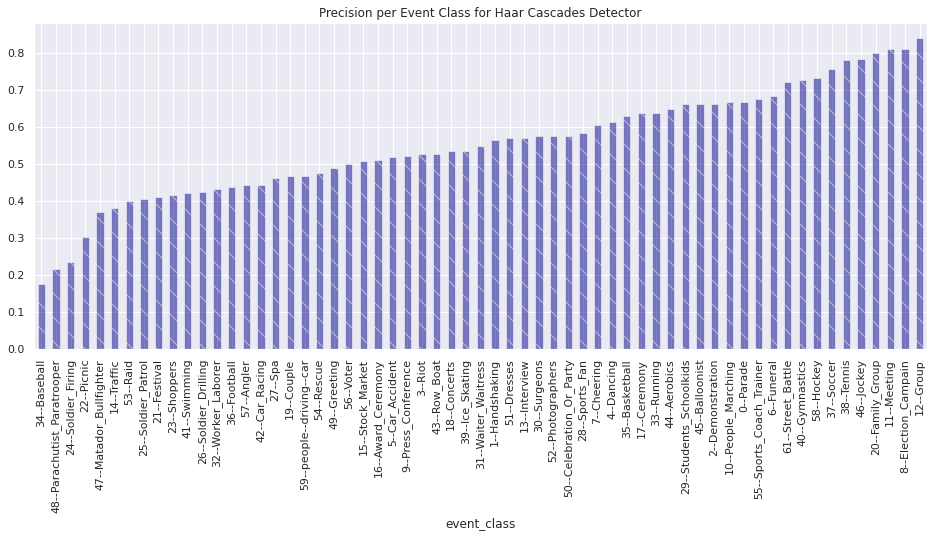

In [121]:
df_event_class_haar.sort_values('precision')['precision'].plot.bar(figsize=(16,6), color='darkblue', 
                                                                   alpha=0.5, log=False, fill=True, hatch='\\');
plt.title('Precision per Event Class for Haar Cascades Detector');

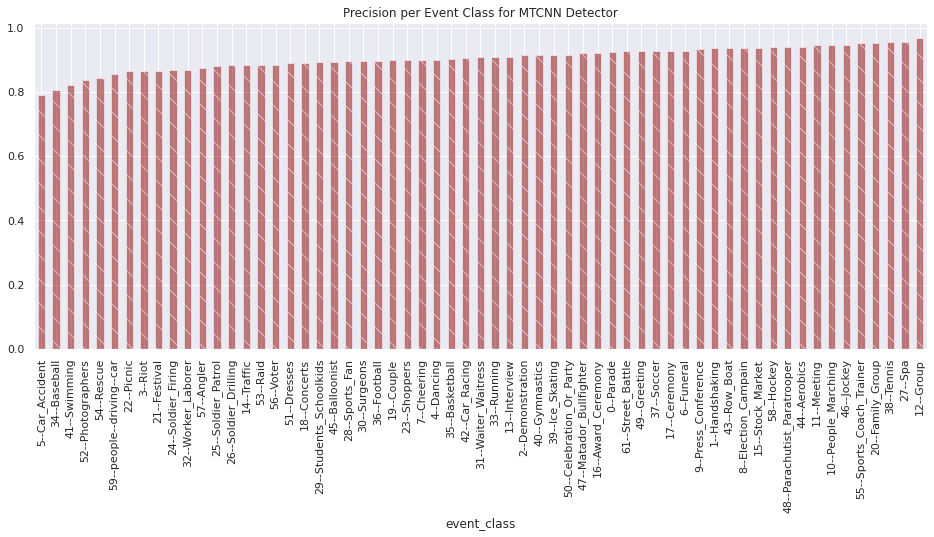

In [122]:
df_event_class_mtcnn.sort_values('precision')['precision'].plot.bar(figsize=(16,6), color='darkred', 
                                                                    alpha=0.5, log=False, fill=True, hatch='\\');
plt.title('Precision per Event Class for MTCNN Detector');

The following bar plots show the Recall evaluated by event class for both models.

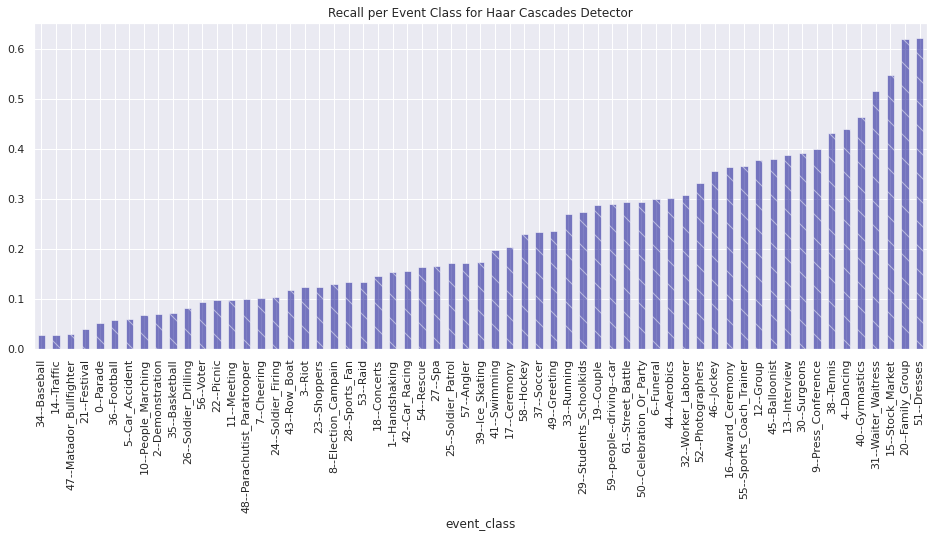

In [123]:
df_event_class_haar.sort_values('recall')['recall'].plot.bar(figsize=(16,6), color='darkblue', 
                                                             alpha=0.5, log=False, fill=True, hatch='\\');
plt.title('Recall per Event Class for Haar Cascades Detector');

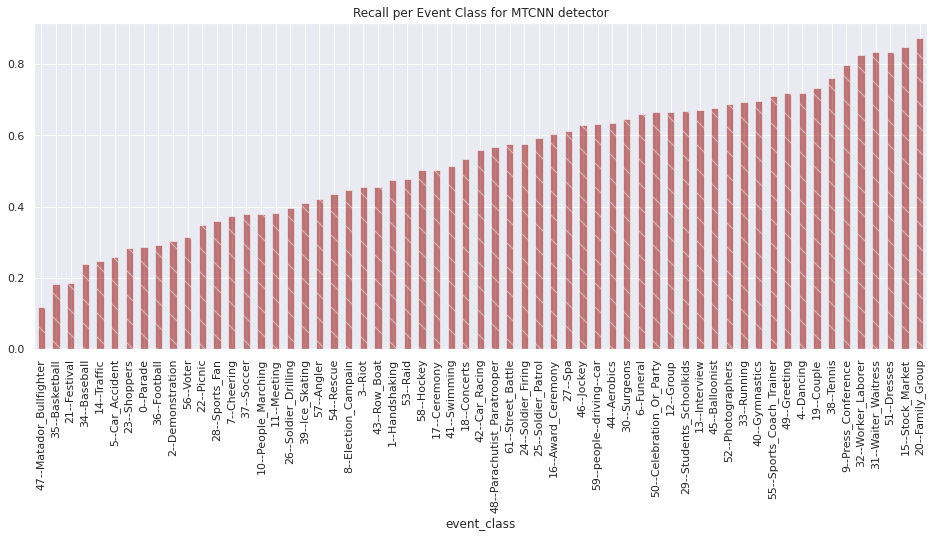

In [124]:
df_event_class_mtcnn.sort_values('recall')['recall'].plot.bar(figsize=(16,6), color='darkred', 
                                                              alpha=0.5, log=False, fill=True, hatch='\\');
plt.title('Recall per Event Class for MTCNN detector');

Obviuosly the two models perform very differently for a single category, in fact the order of the event class is different for the two plots. The worst performance of the MTCNN model is on the "5--Car_Accident" category, instead Haar Cascade worst performance is on "34--Baseball" event class. Both models show their best behavior on "12--Group".

A better visualization for comparison is to plot precision and recall, by event class side by side for both models.

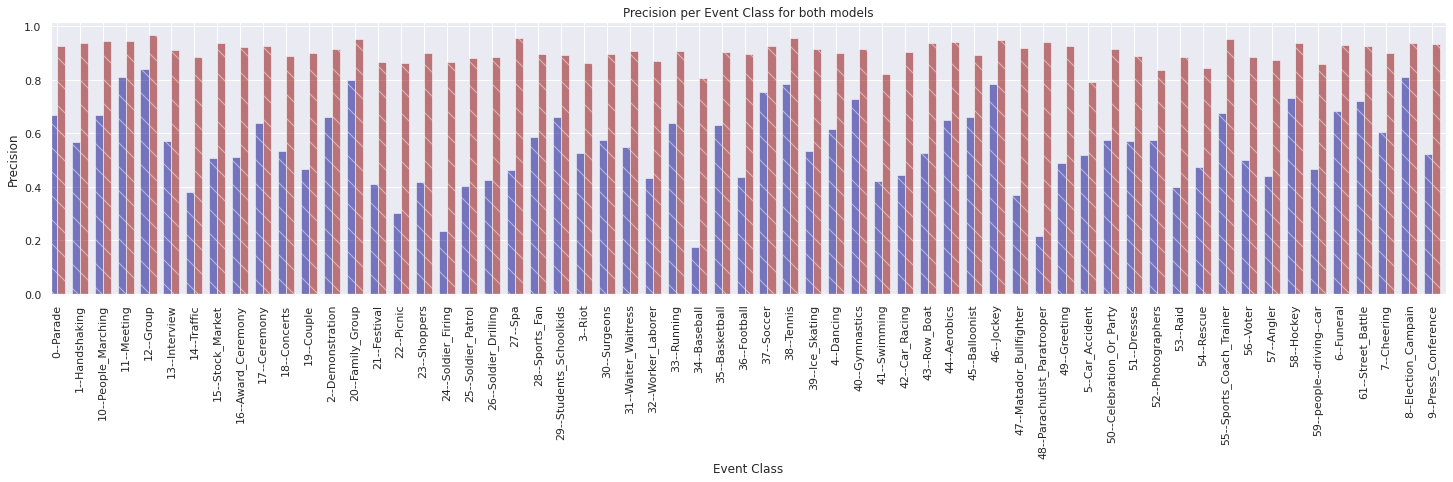

In [125]:
fig = plt.figure(figsize=(25, 5))

ab_bar_list = [df_event_class_haar['precision'].plot.bar(color='darkblue', 
                                                         alpha=0.5, log=False, fill=True, 
                                                         hatch='\\', align='edge', width= -0.35),
               df_event_class_mtcnn['precision'].plot.bar(color='darkred', 
                                                          alpha=0.5, log=False, fill=True, 
                                                          hatch='\\', align='edge', width= 0.35)]
plt.xlabel('Event Class')
plt.ylabel('Precision')
plt.title('Precision per Event Class for both models');

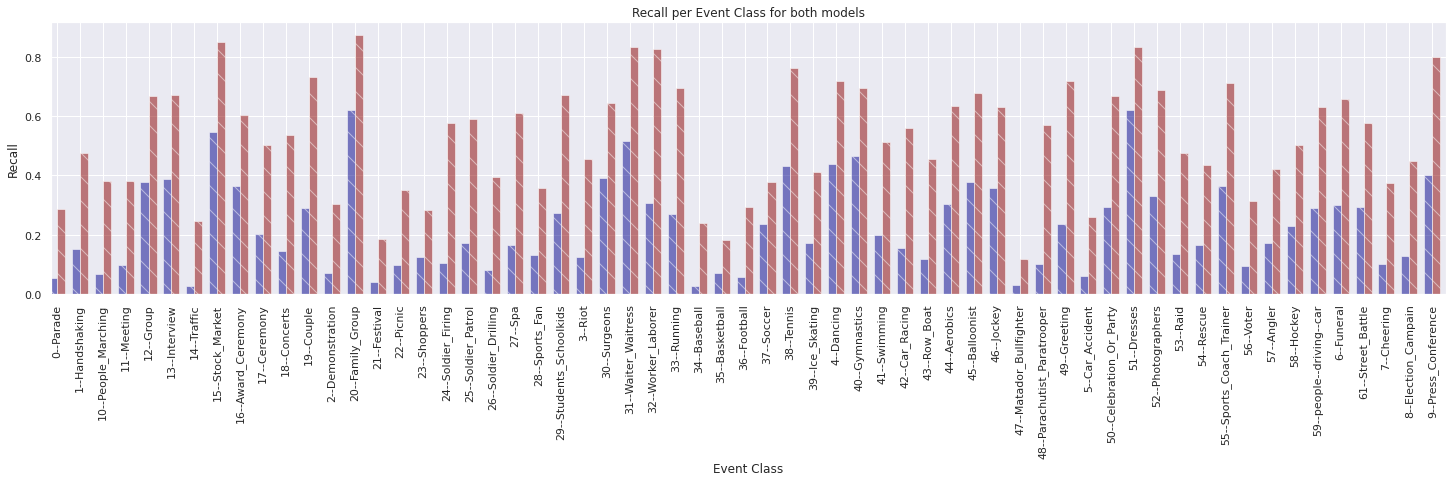

In [126]:
fig = plt.figure(figsize=(25, 5))

ab_bar_list = [df_event_class_haar['recall'].plot.bar(color='darkblue', 
                                                      alpha=0.5, log=False, fill=True, 
                                                      hatch='\\', align='edge', width= -0.35),
               df_event_class_mtcnn['recall'].plot.bar(color='darkred', 
                                                       alpha=0.5, log=False, fill=True, 
                                                       hatch='\\', align='edge', width= 0.35)]
plt.xlabel('Event Class')
plt.ylabel('Recall')
plt.title('Recall per Event Class for both models');

It clearly appear that the MTCNN detector has an higher precision and recall than the Haar Cascades on each event class.

## Part 3:  Understand model when there’s no ground truth.

To keep track of how the model performs in real life without having the ground truth, we need to define a new metrics different from precision and recall.

The reasoning we applied is as follow. 
* We consider the test dataset as our real life case, while the validation dataset as our reference dataset.

* The underling hypothesis is that under common contextual conditions of the images we expect that the model behaves similarly in real life as in the reference dataset. In other words, we expect that the distribution of number of faces is expected to be the same for the  validation and test datasets within the same event class, that identifies the contextual conditions.

* For the validation dataset we have direct access to the number of faces in each image (`t_num_boxes`). 

* For the test dataset we can only estimate it starting from the number of predicted images (`p_num_boxes`). We took it easy here. We estimate the number of faces applying a correction factor to the predicted faces. 
The correction factor is calculated from the validation dataset as the median value of the distribution of the ratio `t_num_boxes / p_num_boxes`. 
We caculate the correction factor for any of the event classes.

* Finally, the new metrics is given by the application of a statistic test that compares the distribution of the number of faces in the validation with the estimated distribution of faces in the test dataset, opportunely scaled. 

* We adopted the chi square test to compare the distributions, and the metrics is the corresponding p_value. 

* For our underline hypothesis, we expect that the two distributions are similar under same contextual conditions. Therefore, a large p_value indicates that the model is behaving as expencted. In contrast, a small p_value (let say < 0.05) indicates that either the model needs revision, or the underling hypothesis is not correct for a specific contextual condition.   


Taking into account the better performance of the Deep Learning (MTCNN) detector, we choose it for the  comparison.

### Choose a Specific Category
According whether the model we are developing need to be used for a particular task, we should select a particular event class.
For example, if we are developing a model to be used on personal smartphones, maybe *20--Family_Group* or *12--Group* could be a good choice.

In [127]:
df_metrics_mtcnn_single_event = df_metrics_mtcnn.loc[df_metrics_mtcnn['event_class'] == '20--Family_Group']
df_metrics_mtcnn_single_event.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58 entries, 732 to 789
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image_name   58 non-null     object 
 1   event_class  58 non-null     object 
 2   p_num_boxes  56 non-null     float64
 3   true_pos     56 non-null     float64
 4   t_num_boxes  58 non-null     int64  
 5   precision    58 non-null     float64
 6   recall       58 non-null     float64
dtypes: float64(4), int64(1), object(2)
memory usage: 3.6+ KB


### Distributions Comparison on Validation dataset 
First of all, we need to create and compare the distributions of the number of expected/predicted bounding boxes per image using the validation dataset.

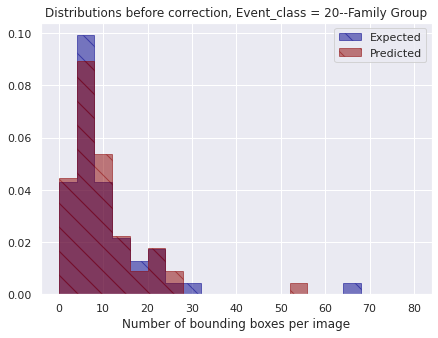

In [128]:
# Distributions of number of expected and predicted bounding box per image'
fig, axes = plt.subplots(figsize=(7,5))

df_metrics_mtcnn_single_event['t_num_boxes'].hist(bins=20, range=(0, 80),
                                                  color='darkblue', alpha=0.5, 
                                                  label = 'Expected', log=False, 
                                                  fill=True, histtype='step', 
                                                  hatch='\\', density=True)
df_metrics_mtcnn_single_event['p_num_boxes'].hist(bins=20, range=(0, 80),
                                                  color='darkred', alpha=0.5, 
                                                  label = 'Predicted', log=False, 
                                                  fill=True, histtype='step', 
                                                  hatch='\\', density=True)
axes.set_xlabel('Number of bounding boxes per image')
axes.legend()
axes.set_title('Distributions before correction, Event_class = 20--Family Group');

Dispite small differences the two distribution match very well. Now, We calculate and apply the correction factor.

In [129]:
# Calculate the correction factor
def get_correction_factor(f1,f2):
  correction_factor = f1/f2
  #cf = correction_factor[correction_factor.notna()].mean()
  cf = np.median(correction_factor[correction_factor.notna()])
  return cf

In [130]:
cf = get_correction_factor(df_metrics_mtcnn_single_event['t_num_boxes'],
                           df_metrics_mtcnn_single_event['p_num_boxes'])
print(f'The correction factor is: {cf:.2f}')

The correction factor is: 1.00


Now we replot the distributions after the correction on *p_num_boxes*:

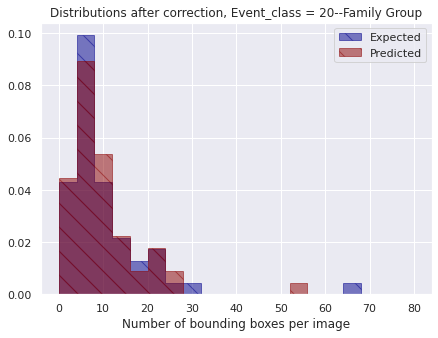

In [131]:
# Distributions of number of expected and predicted bounding box per image'
fig, axes = plt.subplots(figsize=(7,5))

df_metrics_mtcnn_single_event['t_num_boxes'].hist(bins=20, range=(0, 80),
                                                  color='darkblue', alpha=0.5, 
                                                  label = 'Expected', log=False, 
                                                  fill=True, histtype='step', 
                                                  hatch='\\', density=True)
(df_metrics_mtcnn_single_event['p_num_boxes']*cf).hist(bins=20, range=(0, 80),
                                                  color='darkred', alpha=0.5, 
                                                  label = 'Predicted', log=False, 
                                                  fill=True, histtype='step', 
                                                  hatch='\\', density=True)
axes.set_xlabel('Number of bounding boxes per image')
axes.legend()
axes.set_title('Distributions after correction, Event_class = 20--Family Group');

To quantify the agreement we apply the chi square statistics test.

#### ChiSquare Test
We want to compare, bin by bin the expected/predicted distributions. So we could calculate the $\chi^2$ using the frequencies from the histograms. 

The *Chi-Square* is defined as follow:

${\chi}^2 = \sum_{i} \frac{(P_i - E_i)^2}{E_i}$

where $P_i$ are the predicetd values and $E_i$ are the expected ones.

In the following function we evaluate the $\chi^2$ making some adjustment to take care of empty bins.


In [132]:
# Function to calculate the Chi-Square
from scipy import stats

def get_chi_square(f1,f2,cf, max_value):
  hist_gt, _ = np.histogram(f1.values, 20, range=(0,max_value))
  hist_pr, _ = np.histogram(f2.fillna(0).values*cf, 20, range=(0,max_value))
  # Take care of empty bins
  hist_gt[hist_gt==0] = 1
  hist_pr = hist_pr * hist_gt.sum()/hist_pr.sum()
  chi2 = (((hist_pr - hist_gt)**2)/hist_gt).sum()
  # Extract the p_value for the given ddof
  p_value = (stats.chi2.sf(chi2, 19))
  return chi2, p_value


And, calculating the $\chi^2$:

In [133]:
# ChiSquare calculation
chi2, p_value = get_chi_square(df_metrics_mtcnn_single_event['t_num_boxes'], 
                               df_metrics_mtcnn_single_event['p_num_boxes'],cf,80)
print(f'The value of Chi2 is{chi2: .1f}, and the p_value is{p_value: .4f}.')

The value of Chi2 is 18.1, and the p_value is 0.5175.


Looking at the numbers, as expected, now the p-value is high, 52% and the *chi-square* value 18.0, divided by the degrees of fredom(*dof = 20*) is close to 1. 
So, we can infere the two distributions are identical, and the model is performing well. 


### The Test Dataset
Now we can obtain the distribution of estimated number of faces from the test dataset, correct it multiplying by the previous correction factor, and finally compare it with the number of faces from the validation dataset. 

#### Fetching Data
So, first of all, we need to to fetch images from test data set.

In [134]:
# Fetch images from test data set
images_dir = "/content/drive/My Drive/SMITHS/wider_face_data/WIDER_test/images/"
df_images_test = Fetch_WiderFace_images(images_dir)

#### Running the MTCNN model
Now we run our MTCNN model to obtain the predictions. 

In [132]:
# Run the MTCNN detector
df_test_predictions_mtcnn = MTCNN_FaceDetector(df_images_test)


In [36]:
df_test_predictions_mtcnn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87983 entries, 0 to 87982
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   p_num_boxes  87983 non-null  int64 
 1   p_left       87983 non-null  int64 
 2   p_top        87983 non-null  int64 
 3   p_width      87983 non-null  int64 
 4   p_height     87983 non-null  int64 
 5   event_class  87983 non-null  object
 6   image_name   87983 non-null  object
dtypes: int64(5), object(2)
memory usage: 4.7+ MB


We need, as usual, adjust the format to preserve the event class separation.

In [80]:
# Split image_name to extract event_class
df_test_predictions_mtcnn['event_class'] = df_test_predictions_mtcnn['image_path'].apply(lambda x: x.split('/')[8])
df_test_predictions_mtcnn['image_name'] = df_test_predictions_mtcnn['image_path'].apply(lambda x: x.split('/')[9])
# Remove image_path
df_test_predictions_mtcnn.drop(['image_path'], axis=1, inplace=True)
df_test_predictions_mtcnn.head(3)

,p_num_boxes,p_left,p_top,p_width,p_height,event_class,image_name
0,12,436,63,35,45,58--Hockey,58_Hockey_icehockey_puck_58_468.jpg
1,12,671,61,32,40,58--Hockey,58_Hockey_icehockey_puck_58_468.jpg
2,12,542,64,26,39,58--Hockey,58_Hockey_icehockey_puck_58_468.jpg


In [81]:
df_test_predictions_mtcnn.to_csv("/content/drive/My Drive/SMITHS/mtcnn_predictions_test_set.csv", header=True, index=False)

In [135]:
df_test_predictions_mtcnn = pd.read_csv("/content/drive/My Drive/SMITHS/mtcnn_predictions_test_set.csv")

#### Comparing Distributions
Now we are ready to compare the predicted bounding boxes for the test dataset with the truth from validation in order to understand if our model is doing well or not.

First, we select the specific event class:

In [136]:
# Select the event_class
df_test_predictions_mtcnn_single_event = df_test_predictions_mtcnn.loc[df_test_predictions_mtcnn['event_class'] 
                                                                       == '20--Family_Group']
df_test_predictions_mtcnn_single_event.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2746 entries, 58397 to 61142
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   p_num_boxes  2746 non-null   int64 
 1   p_left       2746 non-null   int64 
 2   p_top        2746 non-null   int64 
 3   p_width      2746 non-null   int64 
 4   p_height     2746 non-null   int64 
 5   event_class  2746 non-null   object
 6   image_name   2746 non-null   object
dtypes: int64(5), object(2)
memory usage: 171.6+ KB


The following plot shows the distribution of our metric on images from the test dataset.

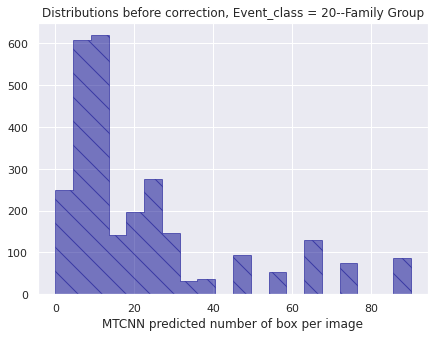

In [139]:
# Plot the predicted number of boxes on test dataset
fig, axes = plt.subplots(figsize=(7,5))

axes.set_xlabel('MTCNN predicted number of box per image')
df_test_predictions_mtcnn_single_event['p_num_boxes'].hist(bins=20, range=(0, 90), color='darkblue', 
                                                           alpha=0.5, log=False, fill=True, 
                                                           histtype='step', hatch='\\')
axes.set_title('Distributions before correction, Event_class = 20--Family Group');

Now, we need to rescale it using the correction  estimated by the previous comparison. Normalize it to take into account the different size of the samples between the test and validation datasets. And finally, superimpose this distribution with the expected number of boxes from the validation.

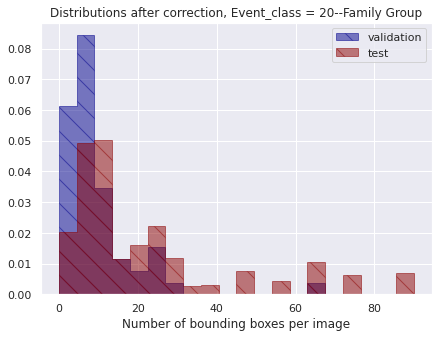

In [138]:
# Plot the predicted number of boxes on test dataset compared to the validation
fig, axes = plt.subplots(figsize=(7,5))

df_metrics_mtcnn_single_event['t_num_boxes'].hist(bins=20, range=(0, 90),
                                                  color='darkblue', alpha=0.5, 
                                                  label = 'validation', log=False, fill=True, 
                                                  histtype='step', hatch='\\', density=True)
(df_test_predictions_mtcnn_single_event['p_num_boxes']*cf).hist(bins=20, range=(0, 90),
                                                             color='darkred', alpha=0.5, 
                                                             label = 'test', log=False, fill=True, 
                                                             histtype='step', hatch='\\', density=True)
axes.set_xlabel('Number of bounding boxes per image')
axes.legend()
axes.set_title('Distributions after correction, Event_class = 20--Family Group');

It seems that the two distributions are different, because of the more populated bins for higher values of bounding box per image. 
We need to apply the statistic test to quantify the disagreement.

Now we repeat the $\chi^2$ test to evaluate the behavior of the MTCNN detector on test dataset.


In [140]:
chi2, p_value = get_chi_square(df_metrics_mtcnn_single_event['t_num_boxes'], 
                               df_test_predictions_mtcnn_single_event['p_num_boxes'],cf,20)
print(f'The value of Chi2 is{chi2: .1f}, and the p_value is{p_value: .4f}.')

The value of Chi2 is 42.3, and the p_value is 0.0016.


Because of the very small p-value, and very high $\chi^2$, we have to say that the two distributions are different. It means that our model is not performing well on the test data set.

Looking at the distributions, the higher population of the bins between 20 and 40 bounding boxes per image, and the less population  of bins with low bounding boxes, suggests that, on the test data set, the model constantly find more objects than exsisting. That means to many false positive.

A possible improvement would be a better tuning of the weights of the MTCNN detector (to save time, we used default weights) to reduce as much as possible the number of false positive, even if that means loosing some detection. 

## Part 4:  Open Question
Having more time for this analysis, there are lot of improvements we should have done.
- **A better parameters tuning.**
At level of detector model, for example, the Haar Cascade has the *scaleFactor* and *minNeighbors* often require tuning for a given image or dataset in order to best detect the faces.
Instead of a quick look at one single image, it should have been helpful to perform a sensitivity analysis across a grid of values and see what works well or best in general on one or multiple event class photograps.
Same consideration is valid for the MTCNN detector with standard weights.

- **A better threshold tuning.**
In order to identify a detection we have applied a cut at 0.5 on the overlap of the predicted and actual bounding boxes (*iou*). With a sensitivity analysis, we should have done an optimization of the ratio between false positive and number of detections.

- **Different factor analysis.** The WIDER FACE dataset is challenging due to large variations in scale, occlusion, pose, and background clutter. These factors are essential to establishing the requirements for a real world system.
The ground truth for the validation data set contains a classification, at level of bounding boxes, of how severe (0=no, 1=partial, 2=heavy) the clutter is.
We would have done a study about the model performance in function, for example, of the level of occlusion.

- **Training the models on Wider Face data set.**
Finally, thanks to the high variety of the Wider Face data set, it should be useful, for better performance, to train the detector models directly using our data set instead of use pre-trained algorithms.


## Bibliography

1 Paul Viola and Michael J. Jones. Robust real-time face detection. International Journal of Computer Vision, 57(2):137–154, 2004. [246]

2 Kaipeng Zhang, Zhanpeng Zhang, Zhifeng Li, Yu Qiao. Joint Face Detection and Alignment using Multi-task Cascaded Convolutional Networks, arXiv:1604.02878 [cs.CV]